In [41]:
import serial
import numpy as np
import time
def isInt(s):
    try: 
        int(s)
        return True
    except ValueError:
        return False
    
from bokeh.io import push_notebook, show, output_notebook
from bokeh.layouts import row
from bokeh.plotting import figure
from bokeh.models.sources import ColumnDataSource
from bokeh.models import Range1d
output_notebook()

Loading BokehJS ...

In [84]:
my_figure = figure(plot_width=800, plot_height=400)
data_source = ColumnDataSource(data=dict(x=[0], y_scl=[0], y_scr=[0]))
scl_line = my_figure.circle("x", "y_scl", source=data_source)
scr_line = my_figure.circle("x", "y_scr", source=data_source, color='orange')
handle = show(my_figure, notebook_handle=True)


In [86]:
usb_port = '/dev/ttyUSB0'

# Hz (500 ms between each measurement)
sample_rate = 100 

# the size of the moving average window in seconds
SCL_window_size_time =  10
SCR_window_size_time = 2

# what's the time step between taking the moving average
step_size_time = 0.1

# Max graph time in seconds
max_graph_time = 30


max_graph_size = int(max_graph_time/step_size_time)

SCL_window_size = int(SCL_window_size_time*sample_rate)
#SCL_step_size = int(SCL_step_size_time*sample_rate)
SCR_window_size = int(SCR_window_size_time*sample_rate)
SCR_step_size = int(step_size_time*sample_rate)



SCL_values = []
SCR_values = []
raw_values = []

counter = 0
SCR_step = 0
SCR_steps = []


with serial.Serial(usb_port, 9600) as ser:
    while True:
        line = ser.readline()
        if (isInt(line.strip())):
            sensorValue = int(line.strip())
            raw_values.append(sensorValue)
            #raw_values = raw_values[-SCL_window_size:]
            if counter % SCR_step_size == 0:
                scr_current = np.mean(raw_values[-SCR_window_size:]) # TODO: moving average window function
                SCR_values.append(scr_current)
                SCR_steps.append(SCR_step)
                SCR_step += step_size_time
                SCL_values.append(np.mean(raw_values[-SCL_window_size:]))
                #print(raw_values[-SCR_window_size:])
                data_source.stream({'x': [SCR_steps[-1]], 'y_scl': [SCL_values[-1]], 
                                    'y_scr': [SCR_values[-1]]}, max_graph_size)                    
                push_notebook(handle=handle)
            counter += 1
        time.sleep(5/1000)

KeyboardInterrupt: 

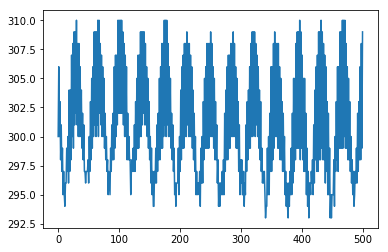

In [98]:
import matplotlib.pyplot as plt
plt.plot(raw_values[5000:5500])
plt.show()

In [52]:
print(minVal)
print(maxVal)

288.525
448.0
